In [2]:
# !pip3 install datasets
# !pip install evaluate
# !pip install seqeval
# !pip install matplotlib
# !pip install seaborn
!pip install torch
!pip install git+https://github.com/kmkurn/pytorch-crf.git

  Cloning https://github.com/kmkurn/pytorch-crf.git to /tmp/pip-req-build-6_dkr9z2
  Running command git clone --filter=blob:none --quiet https://github.com/kmkurn/pytorch-crf.git /tmp/pip-req-build-6_dkr9z2
  Resolved https://github.com/kmkurn/pytorch-crf.git to commit 623e3402d00a2728e99d6e8486010d67c754267b
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import ast
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch

In [4]:
df = pd.read_csv('/kaggle/input/big-ukr/filtered_text_big.csv')

In [5]:
df.columns

Index(['flattened_filtered_text_words', 'flattened_filtered_text_word_labels'], dtype='object')

In [6]:
df['flattened_filtered_text_words'] = df['flattened_filtered_text_words'].apply(ast.literal_eval)
df['flattened_filtered_text_word_labels'] = df['flattened_filtered_text_word_labels'].apply(ast.literal_eval)


In [7]:
length_check_flattened = df.apply(
    lambda row: len(row['flattened_filtered_text_words']) == len(row['flattened_filtered_text_word_labels']), axis=1)
length_check_flattened


0        True
1        True
2        True
3        True
4        True
         ... 
65776    True
65777    True
65778    True
65779    True
65780    True
Length: 65781, dtype: bool

In [8]:
df.columns

Index(['flattened_filtered_text_words', 'flattened_filtered_text_word_labels'], dtype='object')

In [9]:
df.head(4)

,flattened_filtered_text_words,flattened_filtered_text_word_labels
0,"[Напередодні, річниці, 76-денно, локдауну, Уха...","[O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, B-..."
1,"[Німеччина, та, Люксембург, знову, відкрили, с...","[B-LOC, O, B-LOC, O, O, O, O, O, O, O, O, O, O..."
2,"[Однокурсник, засновника, SoftServe, Юрія, Вас...","[O, O, B-ORG, B-PER, I-PER, O, B-PER, I-PER, O..."
3,"[Дослідники, Единбурзького, університету, вияв...","[O, B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O..."


## Крок 1. Створити word2idx і tag2idx

In [10]:
from collections import defaultdict

# Словник, який повертає індекс <UNK> якщо слово не знайдено

# Резервовані токени
word2idx = defaultdict(lambda: word2idx["<UNK>"])
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

unique_words = set(
    word for word in df["flattened_filtered_text_words"].explode().dropna() if isinstance(word, str)
)
for idx, word in enumerate(sorted(unique_words), start=2):
    word2idx[word] = idx

In [11]:
list(unique_words)[:10]

['50-річна',
 'Ocado,',
 '"Схід-Захід",',
 'Бакинську',
 'ЦКС.',
 'дільничною',
 'Лаврова",',
 '"аромат"',
 'платах.',
 'кмітливих']

In [ ]:
print(word2idx["Україна"])
print(word2idx["неіснуючеслово"])
print(word2idx["<PAD>"])

340104
1
0


In [13]:
len(word2idx)

839173

In [14]:
tag2idx = {
    'O': 0,
    'B-PER': 1,
    'I-PER': 2,
    'B-ORG': 3,
    'I-ORG': 4,
    'B-LOC': 5,
    'I-LOC': 6,
}

idx2tag = {v: k for k, v in tag2idx.items()}

In [15]:
idx2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [ ]:
print(tag2idx["B-LOC"])
print(idx2tag[4])

5
I-ORG


In [17]:
label_to_number = {
    'O': 0,
    'B-PER': 1,
    'I-PER': 2,
    'B-ORG': 3,
    'I-ORG': 4,
    'B-LOC': 5,
    'I-LOC': 6,
}
def convert_labels_to_numbers(labels):
    return [label_to_number[label] for label in labels]

df['numeric_labels'] = df['flattened_filtered_text_word_labels'].apply(convert_labels_to_numbers)

In [18]:
print(df[['flattened_filtered_text_word_labels', 'numeric_labels']].head(1))

                 flattened_filtered_text_word_labels  \
0  [O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, B-...   

                                      numeric_labels  
0  [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, ...  


In [19]:
def convert_words_to_ids(words):
    return [word2idx[word] for word in words]

df['input_ids'] = df['flattened_filtered_text_words'].apply(convert_words_to_ids)

In [20]:
print(df[['flattened_filtered_text_words', 'input_ids']].head(1))

                       flattened_filtered_text_words  \
0  [Напередодні, річниці, 76-денно, локдауну, Уха...   

                                           input_ids  
0  [283432, 731236, 110745, 553891, 342205, 79476...  


In [21]:
from torch.utils.data import Dataset, DataLoader

class NERDataset(Dataset):
    def __init__(self, texts, labels, word2idx):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        word_ids = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in self.texts[idx]]
        label_ids = self.labels[idx]
        return {
            "input_ids": torch.tensor(word_ids, dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long)
        }

In [ ]:
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    labels = [item["labels"] for item in batch]
    max_len = max(len(x) for x in input_ids)

    padded_inputs = []
    padded_labels = []
    masks = []

    for i, l in zip(input_ids, labels):
        pad_len = max_len - len(i)
        padded_inputs.append(torch.cat([i, torch.zeros(pad_len, dtype=torch.long)]))
        
        padded_labels.append(torch.cat([l, torch.full((pad_len,), tag2idx['O'], dtype=torch.long)]))
        
        masks.append(torch.cat([torch.ones(len(i)), torch.zeros(pad_len)]))

    return {
        "input_ids": torch.stack(padded_inputs),
        "labels": torch.stack(padded_labels),
        "mask": torch.stack(masks)
    }

In [23]:
df.shape

(65781, 4)

In [24]:
df = df[df['flattened_filtered_text_words'].apply(lambda x: len(x) > 0)]
df = df[df['numeric_labels'].apply(lambda x: len(x) > 0)]

In [25]:
all_rows = 65780
train_data_size = round(all_rows * 0.7, 0)
valid_data_size = round(all_rows * 0.15, 0)
test_data_size = all_rows - train_data_size - valid_data_size

In [26]:
def create_splits(df, train_size, val_size, test_size):
    def count_labels(tags):
        b_per = tags.count(1) 
        i_per = tags.count(2)
        b_org = tags.count(3)
        i_org = tags.count(4)
        b_loc = tags.count(5) 
        i_loc = tags.count(6)
        return {"per": b_per + i_per, "org": b_org + i_org, "loc": b_loc + i_loc}

    df["label_counts"] = df['numeric_labels'].apply(count_labels)
    df["per_count"] = df["label_counts"].apply(lambda x: x["per"])
    df["org_count"] = df["label_counts"].apply(lambda x: x["org"])
    df["loc_count"] = df["label_counts"].apply(lambda x: x["loc"]) 
    
    train_data = df.sample(n=train_size, random_state=21)
    remaining_data = df.drop(train_data.index)
    validation_data = remaining_data.sample(n=val_size, random_state=21)
    test_data = remaining_data.drop(validation_data.index).sample(n=test_size, random_state=21)
    
    print(f"Train size: {len(train_data)} rows")
    print(f"Validation size: {len(validation_data)} rows")
    print(f"Test size: {len(test_data)} rows")
    
    def print_distribution(name, data):
        label_sum = data[["per_count", "org_count", "loc_count"]].sum() 
        total = label_sum["per_count"] + label_sum["org_count"] + label_sum["loc_count"]
        per_percentage = label_sum["per_count"] / total * 100 if total else 0
        org_percentage = label_sum["org_count"] / total * 100 if total else 0
        loc_percentage = label_sum["loc_count"] / total * 100 if total else 0
        print(f"\n{name} label distribution:")
        print(label_sum)
        print(f"{name} label percentages: PER: {per_percentage:.2f}%, ORG: {org_percentage:.2f}%, LOC: {loc_percentage:.2f}%")
    
    print_distribution("Train", train_data)
    print_distribution("Validation", validation_data)
    print_distribution("Test", test_data)
    
    return train_data, validation_data, test_data

train_data, validation_data, test_data = create_splits(df, int(train_data_size), int(valid_data_size), int(test_data_size))


Train size: 46046 rows
Validation size: 9867 rows
Test size: 9867 rows

Train label distribution:
per_count    289479
org_count    427640
loc_count    284004
dtype: int64
Train label percentages: PER: 28.92%, ORG: 42.72%, LOC: 28.37%

Validation label distribution:
per_count    61214
org_count    91880
loc_count    58961
dtype: int64
Validation label percentages: PER: 28.87%, ORG: 43.33%, LOC: 27.80%

Test label distribution:
per_count    62396
org_count    91337
loc_count    62374
dtype: int64
Test label percentages: PER: 28.87%, ORG: 42.26%, LOC: 28.86%


In [27]:
train_dataset = NERDataset(
    texts=train_data["flattened_filtered_text_words"].tolist(),
    labels=train_data["numeric_labels"].tolist(),
    word2idx=word2idx
)

val_dataset = NERDataset(
    texts=validation_data["flattened_filtered_text_words"].tolist(),
    labels=validation_data["numeric_labels"].tolist(),
    word2idx=word2idx
)

test_dataset = NERDataset(
    texts=test_data["flattened_filtered_text_words"].tolist(),
    labels=test_data["numeric_labels"].tolist(),
    word2idx=word2idx
)

In [28]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [29]:
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=256):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, input_ids, labels=None, mask=None):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.bilstm(embeds)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=mask.bool(), reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask.bool())

In [136]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        mask = batch["mask"].to(device)

        loss = model(input_ids, labels=labels, mask=mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    tqdm.write(f"🟢 Avg training loss: {avg_loss:.4f}")
    return avg_loss

In [137]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

def evaluate(model, dataloader, idx2tag, save_report_path=None):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            mask = batch["mask"].to(device)

            loss = model(input_ids, labels=labels, mask=mask)
            total_loss += loss.item()

            predictions = model(input_ids, mask=mask)

            for pred_seq, true_seq, mask_seq in zip(predictions, labels, mask):
                length = int(mask_seq.sum().item())
                pred_seq = pred_seq[:length]
                true_seq = true_seq[:length]
                all_preds.extend(pred_seq)
                all_labels.extend(true_seq.tolist())

    pred_tags = [idx2tag[i] for i in all_preds]
    true_tags = [idx2tag[i] for i in all_labels]

    report = classification_report(true_tags, pred_tags, digits=4, zero_division=0)
    print("📋 Classification Report:\n")
    print(report)

    if save_report_path:
        with open(save_report_path, "w") as f:
            f.write(report)

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_tags, pred_tags, average='weighted', zero_division=0
    )
    accuracy = accuracy_score(true_tags, pred_tags)
    avg_loss = total_loss / len(dataloader)

    return {
        "val_loss": avg_loss,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

In [150]:
def train_model(model, train_loader, val_loader, idx2tag, epochs=15, lr=0.001, patience=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float("inf")
    early_stop_counter = 0

    print(f"{'Epoch':<6} {'TrainLoss':<12} {'ValLoss':<12} {'F1':<8} {'Acc':<8} {'Saved':<6}")
    print("-" * 50)

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer)

        val_metrics = evaluate(
            model, val_loader, idx2tag
        )

        val_loss = val_metrics["val_loss"]
        f1 = val_metrics["f1"]
        acc = val_metrics["accuracy"]

        saved = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            saved = "✅"
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        print(f"{epoch:<6} {train_loss:<12.4f} {val_loss:<12.4f} {f1:<8.4f} {acc:<8.4f} {saved}")

        if early_stop_counter >= patience:
            print(f"\n⏹️ Early stopping triggered after {patience} bad epochs.")
            break

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [ ]:
model = BiLSTM_CRF(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx)
).to(device)

train_model(model, train_loader, val_loader, idx2tag, epochs=15)

Epoch  TrainLoss    ValLoss      F1       Acc      Saved 
--------------------------------------------------


🟢 Avg training loss: 50.8073


Evaluating: 100%|██████████| 309/309 [02:52<00:00,  1.79it/s]


📋 Classification Report:

              precision    recall  f1-score   support

       B-LOC     0.8601    0.7469    0.7995     51538
       B-ORG     0.8116    0.6129    0.6984     54556
       B-PER     0.8535    0.5683    0.6823     39446
       I-LOC     0.7483    0.5475    0.6323      7423
       I-ORG     0.7570    0.6861    0.7198     37324
       I-PER     0.8366    0.7277    0.7784     21768
           O     0.9670    0.9907    0.9787   1700904

    accuracy                         0.9540   1912959
   macro avg     0.8334    0.6971    0.7556   1912959
weighted avg     0.9509    0.9540    0.9511   1912959

1      50.8073      27.6487      0.9511   0.9540   ✅


🟢 Avg training loss: 20.7982


Evaluating: 100%|██████████| 309/309 [02:55<00:00,  1.76it/s]


📋 Classification Report:

              precision    recall  f1-score   support

       B-LOC     0.9014    0.8186    0.8580     51538
       B-ORG     0.8406    0.7055    0.7672     54556
       B-PER     0.8791    0.6726    0.7621     39446
       I-LOC     0.8102    0.6545    0.7240      7423
       I-ORG     0.8211    0.7486    0.7831     37324
       I-PER     0.8778    0.8051    0.8399     21768
           O     0.9758    0.9926    0.9841   1700904

    accuracy                         0.9649   1912959
   macro avg     0.8723    0.7711    0.8169   1912959
weighted avg     0.9631    0.9649    0.9634   1912959

2      20.7982      19.6875      0.9634   0.9649   ✅


🟢 Avg training loss: 13.1355


Evaluating: 100%|██████████| 309/309 [03:53<00:00,  1.33it/s]


📋 Classification Report:

              precision    recall  f1-score   support

       B-LOC     0.8929    0.8553    0.8737     51538
       B-ORG     0.8332    0.7584    0.7941     54556
       B-PER     0.8400    0.7565    0.7960     39446
       I-LOC     0.8306    0.6977    0.7584      7423
       I-ORG     0.8269    0.7904    0.8083     37324
       I-PER     0.8730    0.8488    0.8607     21768
           O     0.9822    0.9905    0.9863   1700904

    accuracy                         0.9688   1912959
   macro avg     0.8684    0.8139    0.8396   1912959
weighted avg     0.9677    0.9688    0.9681   1912959

3      13.1355      17.2898      0.9681   0.9688   ✅


🟢 Avg training loss: 15.2127


Evaluating: 100%|██████████| 309/309 [02:58<00:00,  1.73it/s]


📋 Classification Report:

              precision    recall  f1-score   support

       B-LOC     0.8415    0.7344    0.7843     51538
       B-ORG     0.7281    0.6040    0.6603     54556
       B-PER     0.8357    0.5068    0.6310     39446
       I-LOC     0.6576    0.4618    0.5426      7423
       I-ORG     0.5544    0.7117    0.6233     37324
       I-PER     0.7882    0.7065    0.7451     21768
           O     0.9696    0.9840    0.9768   1700904

    accuracy                         0.9461   1912959
   macro avg     0.7679    0.6727    0.7090   1912959
weighted avg     0.9452    0.9461    0.9442   1912959

4      15.2127      30.0201      0.9442   0.9461   


Training:  27%|██▋       | 383/1439 [08:03<20:53,  1.19s/it]  

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
def predict_on_test_and_plot_confusion_matrix(model, dataloader, idx2tag):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting on test set"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            mask = batch["mask"].to(device)

            predictions = model(input_ids, mask=mask)

            for pred_seq, true_seq, mask_seq in zip(predictions, labels, mask):
                length = int(mask_seq.sum().item())
                pred_seq = pred_seq[:length]
                true_seq = true_seq[:length]
                all_preds.extend(pred_seq)
                all_labels.extend(true_seq.tolist())

    pred_tags = [idx2tag[i] for i in all_preds]
    true_tags = [idx2tag[i] for i in all_labels]

    label_to_number = {
        'O': 0,
        'B-PER': 1,
        'I-PER': 2,
        'B-ORG': 3,
        'I-ORG': 4,
        'B-LOC': 5,
        'I-LOC': 6,
    }
    ordered_labels = list(label_to_number.keys())

    print("\n📋 Classification Report:\n")
    print(classification_report(true_tags, pred_tags, labels=ordered_labels, digits=4, zero_division=0))

    cm = confusion_matrix(true_tags, pred_tags, labels=ordered_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=ordered_labels,
        yticklabels=ordered_labels
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix on Test Set (BiLSTM-CRF)")
    plt.tight_layout()
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_tags, pred_tags, average='weighted', zero_division=0
    )
    accuracy = accuracy_score(true_tags, pred_tags)
    print(f"\n✅ Weighted Avg — Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {accuracy:.4f}")

Predicting on test set: 100%|██████████| 309/309 [00:58<00:00,  5.27it/s]



📋 Classification Report:

              precision    recall  f1-score   support

           O     0.9822    0.9907    0.9864   1689336
       B-PER     0.8454    0.7624    0.8018     40360
       I-PER     0.8748    0.8611    0.8679     22036
       B-ORG     0.8366    0.7615    0.7973     54611
       I-ORG     0.8264    0.7934    0.8095     36726
       B-LOC     0.8960    0.8559    0.8755     54571
       I-LOC     0.8246    0.6783    0.7443      7803

    accuracy                         0.9688   1905443
   macro avg     0.8694    0.8148    0.8404   1905443
weighted avg     0.9678    0.9688    0.9682   1905443



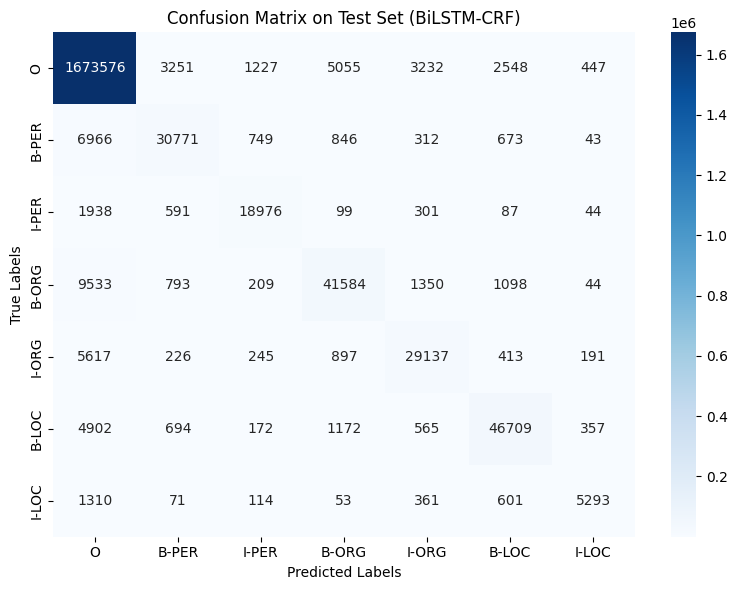


✅ Weighted Avg — Precision: 0.9678 | Recall: 0.9688 | F1: 0.9682 | Accuracy: 0.9688


In [44]:
from tqdm import tqdm
predict_on_test_and_plot_confusion_matrix(model, test_loader, idx2tag)